# Tutorial – Loading and Preprocessing Data with TensorFlow

So far we have used only datasets that fit in memory, but Deep Learning systems are often trained on very large datasets that will not fit in RAM. Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other Deep Learning libraries, but TensorFlow makes it easy thanks to the Data API: you just create a dataset object, and tell it where to get the data and how to transform it. TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, and prefetching. Moreover, the Data API works seamlessly with tf.keras!

Off the shelf, the Data API can read from text files (such as CSV files), binary files with fixed-size records, and binary files that use TensorFlow’s TFRecord format, which supports records of varying sizes. TFRecord is a flexible and efficient binary format usually containing protocol buffers (an open source binary format). The Data API also has support for reading from SQL databases. 

Moreover, many open source extensions are available to read from all sorts of data sources, such as Google’s BigQuery service.

Reading huge datasets efficiently is not the only difficulty: the data also needs to be preprocessed, usually normalized. Moreover, it is not always composed strictly of convenient numerical fields: there may be text features, categorical features, and so on. These need to be encoded, for example using one-hot encoding, bag-of-words encoding, or embeddings (as we will see, an embedding is a trainable dense vector that represents a category or token). One option to handle all this preprocessing is to write your own custom preprocessing layers. Another is to use the standard preprocessing layers provided by Keras.

In this tutorial, we will cover the Data API, the TFRecord format, and how to create custom preprocessing layers and use the standard Keras ones. We will also take a quick look at a few related projects from TensorFlow’s ecosystem:


**TF Transform (tf.Transform)**
Makes it possible to write a single preprocessing function that can be run in batch mode on your full training set, before training (to speed it up), and then exported to a TF Function and incorporated into your trained model so that once it is deployed in production it can take care of preprocessing new instances on the fly.


**TF Datasets (TFDS)**
Provides a convenient function to download many common datasets of all kinds, including large ones like ImageNet, as well as convenient dataset objects to manipulate them using the Data API.

So let’s get started!

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
import warnings
warnings.filterwarnings('ignore')


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
TUTORIAL_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", TUTORIAL_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Datasets with `tf.data.Dataset` API

The whole `tf.data.Dataset` API in Tensorflow revolves around the concept of a `Dataset`: as you might suspect, this represents a sequence of data items.


In tensorflow, the `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

1. Create a source dataset from your input data.
2. Apply dataset transformations to preprocess the data.
3. Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.


Roughly speaking, the `tf.data.Dataset` represents a potentially large set of elements.

```Pthton
tf.data.Dataset(
    variant_tensor
)
```

## List of `tf.data.Dataset` methods

Here is a short description of each method in the `Dataset` class:

In [ ]:
# list all methods of the tf.data.Dataset class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

## `from_tensor_slices()` method

Usually you will use datasets that gradually read data from disk.

The `from_tensor_slices()` method creates a Dataset whose elements are slices of the given tensors.

The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. All input tensors must have the same size in their first dimensions.

```Python
from_tensor_slices(
    tensors, name=None
)
```

Where:

tensors: A dataset element, whose components have the same first dimension. Supported values are documented here.

name: (Optional.) A name for the tf.data operation.

The `from_tensor_slices()` method returns a `tf.data.Dataset` object.

Note that if tensors contains a NumPy array, and eager execution is not enabled, the values will be embedded in the graph as one or more tf.constant operations. For large datasets (> 1 GB), this can waste memory and run into byte limits of graph serialization. If tensors contains one or more large NumPy arrays,

In [ ]:
# Slicing a 1D tensor produces scalar tensor elements.
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])

list(dataset.as_numpy_iterator())

In [ ]:
# Slicing a 2D tensor produces 1D tensor elements.
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])

list(dataset.as_numpy_iterator())

In [ ]:
# Slicing a tuple of 1D tensors produces tuple elements containing
# scalar tensors.
dataset = tf.data.Dataset.from_tensor_slices(([1, 2], [3, 4], [5, 6]))

list(dataset.as_numpy_iterator())

In [ ]:
# Dictionary structure is also preserved.
dataset = tf.data.Dataset.from_tensor_slices({"a": [1, 2], "b": [3, 4]})

list(dataset.as_numpy_iterator()) == [{'a': 1, 'b': 3},
                                      {'a': 2, 'b': 4}]

In [ ]:
# Two tensors can be combined into one Dataset object.
features = tf.constant([[1, 3], [2, 1], [3, 3]]) # ==> 3x2 tensor
labels = tf.constant(['A', 'B', 'A']) # ==> 3x1 tensor
dataset = tf.data.Dataset.from_tensor_slices((features, labels))


In [ ]:
# Both the features and the labels tensors can be converted
# to a Dataset object separately and combined after.
features_dataset = tf.data.Dataset.from_tensor_slices(features)
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
dataset = tf.data.Dataset.zip((features_dataset, labels_dataset))


In [ ]:
# A batched feature and label set can be converted to a Dataset
# in similar fashion.
batched_features = tf.constant([[[1, 3], [2, 3]],
                                [[2, 1], [1, 2]],
                                [[3, 3], [3, 2]]], shape=(3, 2, 2))
batched_labels = tf.constant([['A', 'A'],
                              ['B', 'B'],
                              ['A', 'B']], shape=(3, 2, 1))
dataset = tf.data.Dataset.from_tensor_slices((batched_features, batched_labels))

for element in dataset.as_numpy_iterator():
    print(element)

**Equivalently:**


The `from_tensor_slices()` function takes a tensor and creates a `tf.data.Dataset` whose elements are all the slices of X (along the first dimension), so this dataset contains 10 items: tensors 0, 1, 2, …, 9. 

In this case we would have obtained the same dataset if we had used `tf.data.Dataset.range(10)`.

You can simply iterate over a dataset’s items like this:

In [ ]:
dataset = tf.data.Dataset.range(10)

In [ ]:
for item in dataset:
    print(item)

it is possible to create a dataset object from a dictionary.

In [ ]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

To process lines from files, use `tf.data.TextLineDataset`:

In [ ]:
dataset = tf.data.TextLineDataset(["mydata/file1.txt", "mydata/file2.txt"])

To process records written in the `TFRecord` format, use `TFRecordDataset`:

In [ ]:
dataset = tf.data.TFRecordDataset(["file1.tfrecords", "file2.tfrecords"])

To create a dataset of all files matching a pattern, use `tf.data.Dataset.list_files`:

In [ ]:
dataset = tf.data.Dataset.list_files("mydata/*.txt")

See:
- `tf.data.FixedLengthRecordDataset`
- `tf.data.Dataset.from_generator`
- `TFRecordDataset`
- `TFRecord` 

for more ways to create datasets.

## Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. 

Each method returns a new dataset, so you can chain transformations like this (this chain is illustrated in the following Figure ):

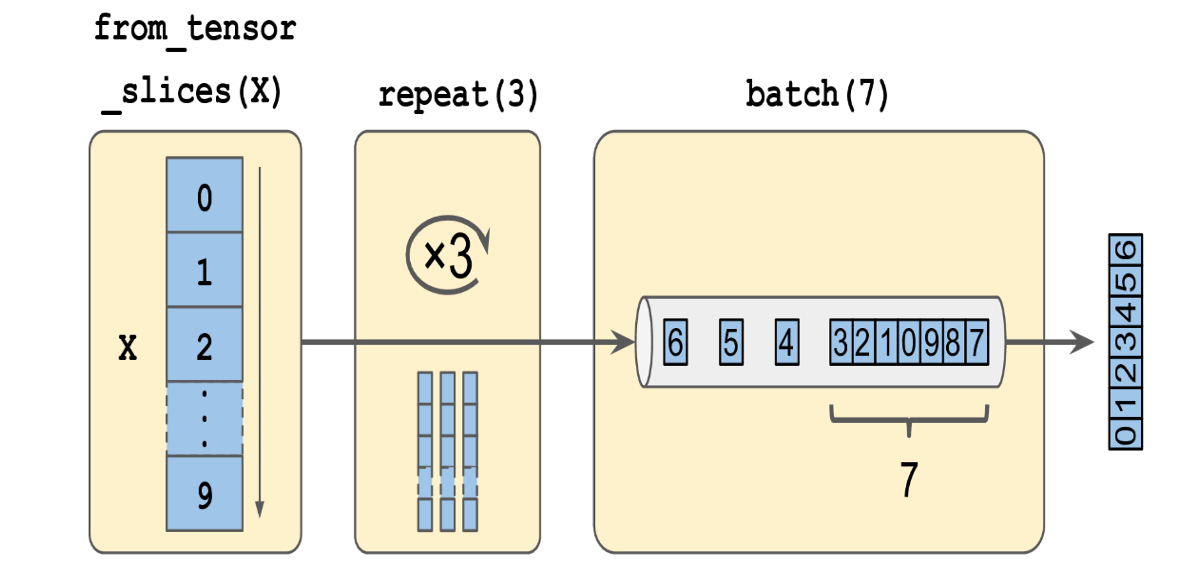

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

In this example, we first call the `repeat() method` on the original dataset, and it returns a new dataset that will repeat the items of the original dataset three times. 

Of course, this will not copy all the data in memory three times!

(If you call this method with no arguments, the new dataset will repeat the source dataset forever, so the code that iterates over the dataset will have to decide when to stop.) 


Then we call the `batch() method` on this new dataset, and again this creates a new dataset. This one will group the items of the previous dataset in batches of seven items. 

Finally, we iterate over the items of this final dataset. 

As you can see, the batch() method had to output a final batch of size two instead of seven, but you can call it with `drop_remainder=True` if you want it to drop this final batch so that all batches have the exact same size.

Common Terms:

**Element**: A single output from calling next() on a dataset iterator. Elements may be nested structures containing multiple components. For example, the element (1, (3, "apple")) has one tuple nested in another tuple. The components are 1, 3, and "apple".

**Component**: The leaf in the nested structure of an element.

**Supported types:**

Elements can be nested structures of tuples, named tuples, and dictionaries. Note that Python lists are not treated as nested structures of components. Instead, lists are converted to tensors and treated as components. For example, the element (1, [1, 2, 3]) has only two components; the tensor 1 and the tensor [1, 2, 3]. Element components can be of any type representable by tf.TypeSpec, including tf.Tensor, tf.data.Dataset, tf.sparse.SparseTensor, tf.RaggedTensor, and tf.TensorArray.

In [ ]:
import collections

a = 1 # Integer element
b = 2.0 # Float element
c = (1, 2) # Tuple element with 2 components
d = {"a": (2, 2), "b": 3} # Dict element with 3 components

Point = collections.namedtuple("Point", ["x", "y"])
e = Point(1, 2) # Named tuple
f = tf.data.Dataset.range(10) # Dataset element

**WARNING**

The dataset methods do not modify datasets, they create new ones, so make sure to keep a reference to these new datasets (e.g., with dataset = ...), or else nothing will happen.

##  `map()` method

You can also transform the items by calling the `map()` method. For example, this creates a new dataset with all items doubled:


In [ ]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch

This function is the one you will call to apply any preprocessing you want to your data.

Sometimes this will include computations that can be quite intensive, such as reshaping or rotating an image, so you will usually want to spawn multiple threads to speed things up: 
it’s as simple as setting the `num_parallel_calls` argument. 

Note that the function you pass to the `map() method` must be convertible to a TF Function. 

In [ ]:
for item in dataset:
    print(item)

## `apply()` method


While the `map() method` applies a transformation to each item, the `apply() method` applies a transformation fucntion to the dataset as a whole. 

In fact, the `apply()` enables chaining of custom Dataset transformations, which are represented as functions that take one Dataset argument and return a transformed Dataset.

Roughly speaking, the apply() applies a transformation function to this dataset.

```Pyhton
apply(
    transformation_func
)
```

The apply() returns a new `tf.data.Dataset` object with the transformation applied as described above.

In [ ]:
dataset = tf.data.Dataset.range(100)

def dataset_fn(ds):
    return ds.filter(lambda x: x < 5)

dataset = dataset.apply(dataset_fn)
list(dataset.as_numpy_iterator())

## `filter()` method

It is also possible to simply filter the dataset according to a predicate using the filter() method:



In [ ]:
# Exxample 1
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)


In [ ]:
#Example 2:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.filter(lambda x: x < 3)
list(dataset.as_numpy_iterator())

# `tf.math.equal(x, y)` is required for equality comparison
def filter_fn(x):
    return tf.math.equal(x, 1)

dataset = dataset.filter(filter_fn)
list(dataset.as_numpy_iterator())


The predicate is a function mapping a dataset element to a boolean.

The `filter()` method returns a new Dataset with the transformation applied as described above.

## `take()` method

You will often want to look at just a few items from a dataset. You can use the take() method for that:

In [ ]:
for item in dataset.take(3):
    print(item)

## `shuffle()` method

As you know, Gradient Descent works best when the instances in the training set are independent and identically distributed.

A simple way to ensure this is to shuffle the instances, using the `shuffle()` method. It will create a new dataset that will start by filling up a buffer with the first items of the source dataset. 

Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. At this point it continues to pull out items randomly from the buffer until it is empty. 

You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective.

Just don’t exceed the amount of RAM you have, and even if you have plenty of it, there’s no need to go beyond the dataset’s size. You can provide a random seed if you want the same random order every time you run your program.

For example, the following code creates and displays a dataset containing the integers 0 to 9, repeated 3 times, shuffled using a buffer of size 5 and a random seed of 42, and batched with a batch size of 7:

In [ ]:
tf.random.set_seed(42)

dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

**TIP**

If you call repeat() on a shuffled dataset, by default it will generate a new order at every iteration. 

This is generally a good idea, but if you prefer to reuse the same order at each iteration (e.g., for tests or debugging), you can set `reshuffle_each_iteration=False`.

For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to the dataset.

One solution is to shuffle the source data itself (for example, on Linux you can shuffle text files using the shuf command). This will definitely improve shuffling a lot! 

Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order). 

To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training. 

However, instances located in the same file will still end up close to each other. To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records. Then on top of that you can add a shuffling buffer using the shuffle() method.


If all this sounds like a lot of work, don’t worry: the Data API makes all this possible in just a few lines of code. Let’s see how to do this.

## `interleave()` method 

The `interleave()` method maps `map_func` across the dataset, and interleaves the results.

The general syntax:

```Python 
interleave(
    map_func,
    cycle_length=None,
    block_length=None,
    num_parallel_calls=None,
    deterministic=None,
    name=None
)
```

The general syntax looks like:

```Python 
def interleave(
  self: Dataset[T],
  map_func: Callable[[T], Dataset[S]]
) -> Dataset[S]
```

The `interleave()` returns A new Dataset with the transformation applied as described above.

For example, you can use `tf.data.Dataset.interleave()` to process many input files concurrently:

In [ ]:
# Preprocess 4 files concurrently, and interleave blocks of 16 records
# from each file.
filenames = ["/var/data/file1.txt", "/var/data/file2.txt",
             "/var/data/file3.txt", "/var/data/file4.txt"]

dataset = tf.data.Dataset.from_tensor_slices(filenames)

def parse_fn(filename):
    return tf.data.Dataset.range(10)

dataset = dataset.interleave(lambda x:
    tf.data.TextLineDataset(x).map(parse_fn, num_parallel_calls=1),
    cycle_length=4, block_length=16)

The `cycle_length` and `block_length` arguments control the order in which elements are produced. 
`cycle_length` controls the number of input elements that are processed concurrently. 

If you set cycle_length to 1, this transformation will handle one input element at a time, and will produce identical results to `tf.data.Dataset.flat_map`.

In general, this transformation will apply `map_func` to `cycle_length` input elements, open iterators on the returned Dataset objects, and cycle through them producing `block_length` consecutive elements from each iterator, and consuming the next input element each time it reaches the end of an iterator.

In [ ]:
#For example:
dataset = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
# NOTE: New lines indicate "block" boundaries.

dataset = dataset.interleave(
    lambda x: tf.data.Dataset.from_tensors(x).repeat(6), cycle_length=2, block_length=4)
list(dataset.as_numpy_iterator())


## `from_generator` method

The `from_generator` method creates a Dataset whose elements are generated by generator.

The general syntax:


```Pyhton
from_generator(
    generator,
    args=None,
    output_signature=None,
    name=None
)
```

The generator argument must be a callable object that returns an object that supports the `iter()` protocol (e.g. a generator function).

**Arguments**
- generator: A callable object that returns an object that supports the iter() protocol. If args is not specified, generator must take no arguments; otherwise it must take as many arguments as there are values in args.

- args: (Optional.) A tuple of tf.Tensor objects that will be evaluated and passed to generator as NumPy-array arguments.

- output_signature(Optional.) A (nested) structure of tf.TypeSpec objects corresponding to each component of an element yielded by generator.

- name (Optional.) A name for the tf.data operations used by from_generator


The `from_generator` method returns a `tf.data.Dataset` object

The recommended way to call from_generator is to use the output_signature argument. In this case the output will be assumed to consist of objects with the classes, shapes and types defined by tf.TypeSpec objects from output_signature argument:

In [ ]:
def gen():
    ragged_tensor = tf.ragged.constant([[1, 2], [3]])
    yield 42, ragged_tensor

dataset = tf.data.Dataset.from_generator(
     gen,
     output_signature=(
         tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.RaggedTensorSpec(shape=(2, None), dtype=tf.int32)))

list(dataset.take(1))



## Case-study : Interleaving Lines from Multiple Files

In this example, let’s suppose that you’ve loaded the California housing dataset, shuffled it (unless it was already shuffled), and split it into a training set, a validation set, and a test set.

### Split the California dataset to multiple CSV files

We split each set into many CSV files that each look like this (each row contains eight input features plus the target median house value):

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import fetch_california_housing


housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)


For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. 


To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [ ]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [ ]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [ ]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

or a read a particular line

In [ ]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

Or in text mode:

In [ ]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

In [ ]:
train_filepaths

### Building an Input Pipeline

Let’s also suppose train_filepaths contains the list of training file paths (and you also have valid_filepaths and test_filepaths):

```Python
train_filepaths
['datasets/housing/my_train_00.csv', 'datasets/housing/my_train_01.csv',...]
 ```


Alternatively, you could use file patterns; for example, train_filepaths = "datasets/housing/my_train_*.csv". Now let’s create a dataset containing only these file paths:

In [ ]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [ ]:
for filepath in filepath_dataset:
    print(filepath)

By default, the `list_files()` function returns a dataset that shuffles the file paths.

In general this is a good thing, but you can set shuffle=False if you do not want that for some reason.

In our example, we call the `interleave() method` to read from five files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the `skip() method`):

In [ ]:


n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

The `interleave() method` will create a dataset that will pull five file paths from the `filepath_dataset`, and for each one it will call the function you gave it (a lambda in this example) to create a new dataset (in this case a TextLineDataset). 

To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five `TextLineDatasets` created internally by the interleave dataset. 

When we iterate over the interleave dataset, it will cycle through these five `TextLineDatasets`, reading one line at a time from each until all datasets are out of items. Then it will get the next five file paths from the `filepath_dataset` and interleave them the same way, and so on until it runs out of file paths.

**TIP**


For interleaving to work best, it is preferable to have files of identical length; otherwise the ends of the longest files will not be interleaved.

By default, `interleave()` does not use parallelism; it just reads one line at a time from each file, sequentially. 

If you want it to actually read files in parallel, you can set the `num_parallel_calls argument` to the number of threads you want (note that the `map()` method also has this argument). 

You can even set it to `tf.data.experimental.AUTOTUNE` to make TensorFlow choose the right number of threads dynamically based on the available CPU (however, this is an experimental feature for now). 

Let’s look at what the dataset contains now:

In [ ]:
for line in dataset.take(5):
    print(line.numpy())

These are the first rows (ignoring the header row) of five CSV files, chosen randomly. 

Looks good! 

But as you can see, these are just byte strings; we need to parse them and scale the data.



Notice that field 4 is interpreted as a string.

In [ ]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

Notice that all missing fields are replaced with their default value, when provided:

In [ ]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

The 5th field is compulsory (since we provided `tf.constant([])` as the "default value"), so we get an exception if we do not provide it:

In [ ]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

The number of fields should match exactly the number of fields in the `record_defaults`:

In [ ]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

### Preprocessing the Data

Let’s implement a small function that will perform this preprocessing:

In [ ]:
# compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_mean, X_std = scaler.mean_, scaler.scale_  


In [ ]:
n_inputs = 8# X_train.shape[-1]

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [ ]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

Let’s walk through this code:

* First, the code assumes that we have precomputed the mean and standard deviation of each feature in the training set. 
`X_mean` and `X_std` are just 1D tensors (or NumPy arrays) containing eight floats, one per input feature.


* The `preprocess() function` takes one CSV line and starts by parsing it. For this it uses the `tf.io.decode_csv() function`, which takes two arguments: the first is the line to parse, and the second is an array containing the default value for each column in the CSV file. This array tells TensorFlow not only the default value for each column, but also the number of columns and their types.
In this example, we tell it that all feature columns are floats and that missing values should default to 0, but we provide an empty array of type `tf.float32` as the default value for the last column (the target): the array tells TensorFlow that this column contains floats, but that there is no default value, so it will raise an exception if it encounters a missing value.


* The `decode_csv() function` returns a list of scalar tensors (one per column), but we need to return 1D tensor arrays. So we call tf.stack() on all tensors except for the last one (the target): this will stack these tensors into a 1D array. We then do the same for the target value (this makes it a 1D tensor array with a single value, rather than a scalar tensor).


* Finally, we scale the input features by subtracting the feature means and then dividing by the feature standard deviations, and we return a tuple containing the scaled features and the target.


Let’s test this preprocessing function:
    

In [ ]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

Looks good! We can now apply the function to the dataset.

### Putting Everything Together wiht Prefetching


To make the code reusable, let’s put together everything we have discussed so far into a small helper function: it will create and return a dataset that will efficiently load California housing data from multiple CSV files, preprocess it, shuffle it, optionally repeat it, and batch it (see Figure below):

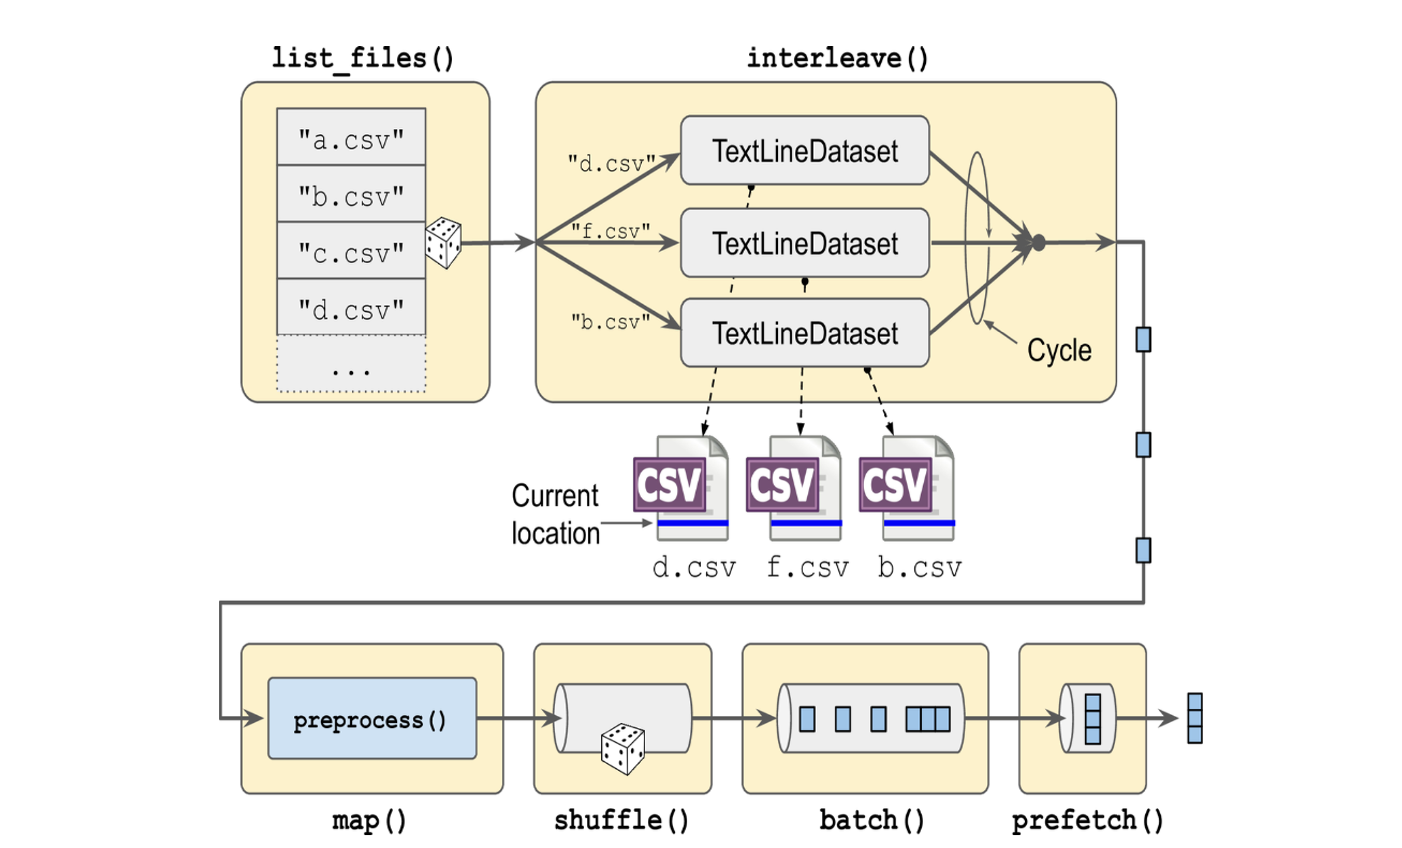

In [ ]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    
    return dataset.batch(batch_size).prefetch(1)

Everything should make sense in this code, except the very last line (`prefetch(1)`), which is important for performance.

### Prefetching

By calling prefetch(1) at the end, we are creating a dataset that will do its best to always be one batch ahead.

In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it). 

This can improve performance dramatically, as is illustrated in the Figure below. 

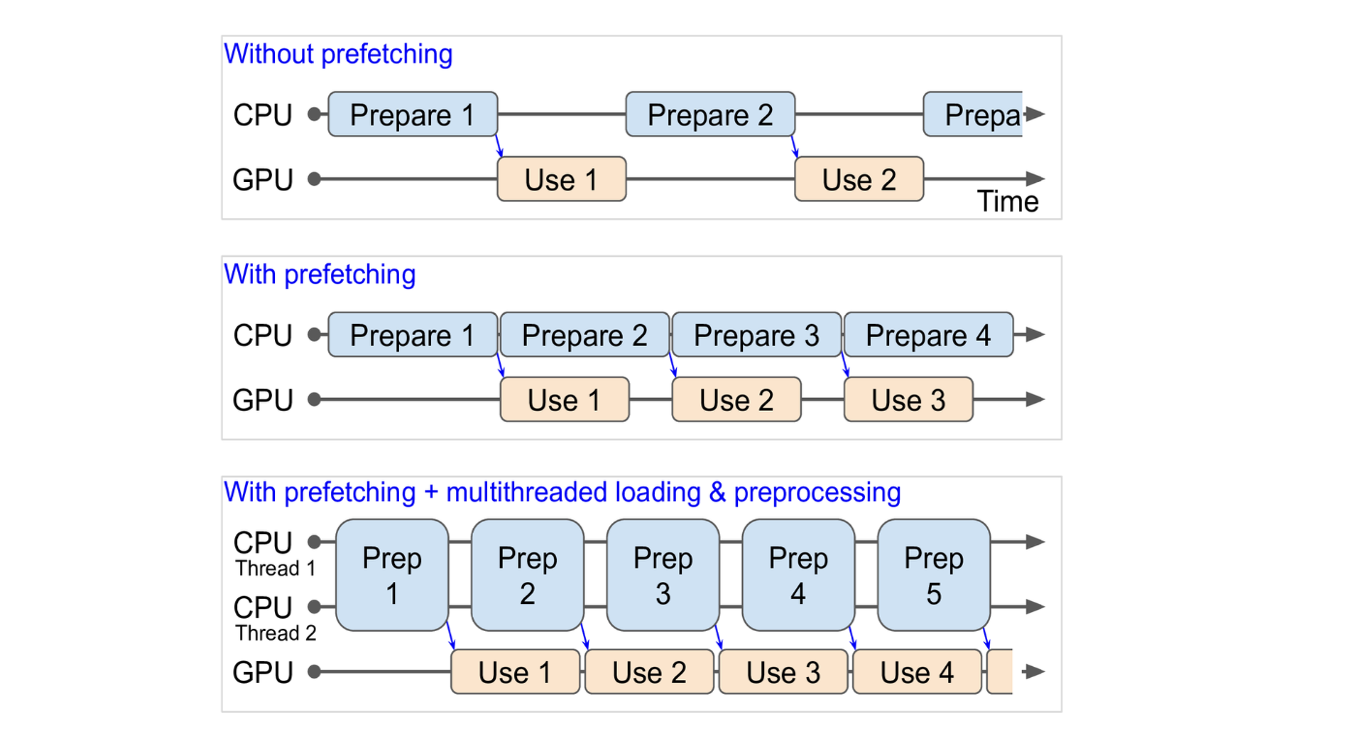

If we also ensure that `loading` and `preprocessing` are `multithreaded` (by setting `num_parallel_calls` when calling `interleave()` and `map()`), we can exploit multiple cores on the CPU and hopefully make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be almost 100% utilized (except for the data transfer time from the CPU to the GPU3), and training will run much faster.

**TIP**

If you plan to purchase a GPU card, its processing power and its memory size are of course very important (in particular, a large amount of RAM is crucial for computer vision). 

Just as important to get good performance is its memory bandwidth; this is the number of gigabytes of data it can get into or out of its RAM per second.

If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset’s `cache() method` to cache its content to RAM.

You should generally do this after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching. This way, each instance will only be read and preprocessed once (instead of once per epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance.



You now know how to build efficient input pipelines to load and preprocess data from multiple text files. We have discussed the most common dataset methods, but there are a few more you may want to look at: 
* concatenate(), 
* zip(), 
* window(), 
* reduce(), 
* shard(), 
* flat_map(), and 
* padded_batch().

There are also a couple more class methods: `from_generator()` and `from_tensors()`, which create a new dataset from a Python generator or a list of tensors, respectively. Please check the API documentation for more details. 

Also note that there are experimental features available in `tf.data.experimental`, many of which will likely make it to the core API in future releases (e.g., check out the `CsvDataset class`, as well as the `make_csv_dataset() method`, which takes care of inferring the type of each column).

# The `TFRecord` binary format

The TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently.

It is a very simple binary format that just contains a sequence of binary records of varying sizes (each record is comprised of a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data). 

[TFRecords tutorial](https://www.tensorflow.org/tutorials/load_data/tfrecord#tfrecord_files_using_tfdata)

## `tf.io.TFRecordWriter` class
You can easily create a TFRecord file using the `tf.io.TFRecordWriter class`:


PS: A TFRecord file is just a list of binary records. You can create one using a `tf.io.TFRecordWriter`:

In [ ]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

## `tf.data.TFRecordDataset` method

And you can read it using a `tf.data.TFRecordDataset`:

In [ ]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

**TIP**

By default, a `TFRecordDataset` will read files one by one, but you can make it read multiple files in parallel and interleave their records by setting `num_parallel_reads`. 

Alternatively, you could obtain the same result by using `list_files()` and `interleave()` as we did earlier to read multiple CSV files.

You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [ ]:
#shows how to read multiple files in parallel and interleave them

filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

## Compressed TFRecord Files

It can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection. 

You can create a compressed TFRecord file by setting the options argument:

In [ ]:
options = tf.io.TFRecordOptions(compression_type="GZIP")

with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

When reading a compressed TFRecord file, you need to specify the compression type:

In [ ]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

# A Brief Intro to Protocol Buffers (Optional)

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads). 

In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type `tf.train.Example`, which are generally sufficient.

However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

Even though each record can use any binary format you want, TFRecord files usually contain serialized protocol buffers (also called protobufs). 

This is a portable, extensible, and efficient binary format developed at Google back in 2001 and made open source in 2008; protobufs are now widely used, in particular in gRPC, Google’s remote procedure call system. 

They are defined using a simple language that looks like this:

```Python
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}
```

This definition says we are using version 3 of the protobuf format, and it specifies that each Person object6 may (optionally) have a name of type string, an id of type int32, and zero or more email fields, each of type string. 

The numbers 1, 2, and 3 are the field identifiers: they will be used in each record’s binary representation. Once you have a definition in a .proto file, you can compile it. 

This requires protoc, the protobuf compiler, to generate access classes in Python (or some other language). 


Note that the protobuf definitions we will use have already been compiled for you, and their Python classes are part of TensorFlow, so you will not need to use protoc. 

All you need to know is how to use protobuf access classes in Python. To illustrate the basics, let’s look at a simple example that uses the access classes generated for the Person protobuf (the code is explained in the comments):

In [ ]:

%%writefile person.proto
syntax = "proto3";
message Person{
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [ ]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [ ]:
!ls person*

In [ ]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

In [ ]:
person.name  # read a field

In [ ]:
person.name = "Alice"  # modify a field

In [ ]:
person.email[0]  # repeated fields can be accessed like arrays

In [ ]:
person.email.append("c@d.com")  # add an email address

In [ ]:
s = person.SerializeToString()  # serialize to a byte string
s

In [ ]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

In [ ]:
person == person2  # now they are equal

In short, we import the Person class generated by protoc, we create an instance and play with it, visualizing it and reading and writing some fields, then we serialize it using the SerializeToString() method. This is the binary data that is ready to be saved or transmitted over the network. When reading or receiving this binary data, we can parse it using the ParseFromString() method, and we get a copy of the object that was serialized.7

We could save the serialized Person object to a TFRecord file, then we could load and parse it: everything would work fine. However, SerializeToString() and ParseFromString() are not TensorFlow operations (and neither are the other operations in this code), so they cannot be included in a TensorFlow Function (except by wrapping them in a tf.py_function() operation, which would make the code slower and less portable). 


Fortunately, TensorFlow does include special protobuf definitions for which it provides parsing operations.

## Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [ ]:
# Shows how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=s, #serialized
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

For more details, see the [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) documentation.

## TensorFlow Protobufs

The main protobuf typically used in a TFRecord file is the Example protobuf, which represents one instance in a dataset. 

It contains a list of named features, where each feature can either be a list of byte strings, a list of floats, or a list of integers. 


Here is the definition of the tf.train.Example protobuf:

```proto3
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

The definitions of BytesList, FloatList, and Int64List are straightforward enough.


Note that `[packed = true]` is used for repeated numerical fields, for a more efficient encoding. A Feature contains either a BytesList, a FloatList, or an Int64List. 


A Features (with an s) contains a dictionary that maps a feature name to the corresponding feature value. 

And finally, an Example contains only a Features object.


Here is how you could create a tf.train.Example representing the same person as earlier and write it to a TFRecord file:

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

The code is a bit verbose and repetitive, but it’s rather straightforward (and you could easily wrap it inside a small helper function). 


Now that we have an Example protobuf, we can serialize it by calling its `SerializeToString() method`, then write the resulting data to a `TFRecord` file:

In [ ]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

Normally you would write much more than one Example! Typically, you would create a conversion script that reads from your current format (say, CSV files), creates an Example protobuf for each instance, serializes them, and saves them to several TFRecord files, ideally shuffling them in the process. This requires a bit of work, so once again make sure it is really necessary (perhaps your pipeline works fine with CSV files).


Now that we have a nice TFRecord file containing a serialized Example, let’s try to load it.

### Loading and Parsing Examples

To load the serialized Example protobufs, we will use a tf.data.TFRecordDataset once again, and we will parse each Example using tf.io.parse_single_example().


This is a TensorFlow operation, so it can be included in a TF Function. It requires at least two arguments: a string scalar tensor containing the serialized data, and a description of each feature. 


The description is a dictionary that maps each feature name to either a `tf.io.FixedLenFeature` descriptor indicating the feature’s shape, type, and default value, or a `tf.io.VarLenFeature` descriptor indicating only the type (if the length of the feature’s list may vary, such as for the "emails" feature).


The following code defines a description dictionary, then it iterates over the `TFRecordDataset` and parses the serialized Example protobuf this dataset contains:

In [ ]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

The fixed-length features are parsed as regular tensors, but the variable-length features are parsed as sparse tensors. 


You can convert a sparse tensor to a dense tensor using `tf.sparse.to_dense()`, but in this case it is simpler to just access its values:

In [ ]:
parsed_example

In [ ]:
parsed_example

In [ ]:
parsed_example["emails"].values[0]

In [ ]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

In [ ]:
parsed_example["emails"].values

A BytesList can contain any binary data you want, including any serialized object. 


For example, you can use `tf.io.encode_jpeg()` to encode an image using the JPEG format and put this binary data in a BytesList. 


Later, when your code reads the TFRecord, it will start by parsing the Example, then it will need to call `tf.io.decode_jpeg()` to parse the data and get the original image (or you can use tf.io.decode_image(), which can decode any BMP, GIF, JPEG, or PNG image). 


You can also store any tensor you want in a BytesList by serializing the tensor using tf.io.serialize_tensor() then putting the resulting byte string in a BytesList feature. Later, when you parse the TFRecord, you can parse this data using `tf.io.parse_tensor()`.

Instead of parsing examples one by one using tf.io.parse_single_example(), you may want to parse them batch by batch using `tf.io.parse_example()`:


```python 

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)
    ```
    
    
As you can see, the Example protobuf will probably be sufficient for most use cases. 



However, it may be a bit cumbersome to use when you are dealing with lists of lists. 

For example, suppose you want to classify text documents. Each document may be represented as a list of sentences, where each sentence is represented as a list of words.


And perhaps each document also has a list of comments, where each comment is represented as a list of words. 


There may be some contextual data too, such as the document’s author, title, and publication date. TensorFlow’s SequenceExample protobuf is designed for such use cases.

### Handling Lists of Lists Using the SequenceExample Protobuf**


Here is the definition of the SequenceExample protobuf:

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```


A `SequenceExample` contains a Features object for the contextual data and a `FeatureLists` object that contains one or more named `FeatureList` objects (e.g., a `FeatureList` named "content" and another named "comments"). 


Each `FeatureList` contains a list of Feature objects, each of which may be a list of byte strings, a list of 64-bit integers, or a list of floats (in this example, each Feature would represent a sentence or a comment, perhaps in the form of a list of word identifiers). 


Building a `SequenceExample`, serializing it, and parsing it is similar to building, serializing, and parsing an Example, but you must use `tf.io.parse_single_sequence_example()` to parse a single `SequenceExample` or `tf.io.parse_sequence_example()` to parse a batch. 


Both functions return a tuple containing the context features (as a dictionary) and the feature lists (also as a dictionary).

If the feature lists contain sequences of varying sizes (as in the preceding example), you may want to convert them to ragged tensors, using `tf.RaggedTensor.from_sparse()`

(see the notebook for the full code):

```Python
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])
Now that you know how to efficiently store, load, and parse data, the next step is to prepare it so that it can be fed to a neural network.
```

### Putting Images in TFRecords

In [ ]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

Now let's create an Example protobuf containing the image encoded as JPEG:

In [ ]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

Finally, let's create a tf.data pipeline that will read this TFRecord file, parse each Example protobuf (in this case just one), and parse and display the image that the example contains:

In [ ]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)

for image in dataset:
    plt.imshow(image)
    plt.title("Decoded Image")
    plt.axis("off")
    plt.show()

### Putting Tensors and Sparse Tensors in TFRecords

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:
Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [ ]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

In [ ]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

In [ ]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

In [ ]:
BytesList(value=serialized_sparse.numpy())

In [ ]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [ ]:
parsed_examples

### Handling Sequential Data Using `SequenceExample`


```Pyhton
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

**Warning**: there's currently a bug preventing `from tensorflow.train import X` so we work around it by writing `X = tf.train.X`. See https://github.com/tensorflow/tensorflow/issues/33289 for more details.

In [ ]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample


context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [ ]:
sequence_example

In [ ]:
serialized_sequence_example = sequence_example.SerializeToString()

In [ ]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [ ]:
parsed_context

In [ ]:
parsed_context["title"].values

In [ ]:
parsed_feature_lists

In [ ]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

Now that you know how to efficiently store, load, and parse data, the next step is to prepare it so that it can be fed to a neural network.

# TensorFlow Datasets (`TFDS`)

The [TensorFlow Datasets](https://www.tensorflow.org/datasets) (TFDS) project is is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks, such as Jax. All datasets are exposed as `tf.data.Datasets`, enabling easy-to-use and high-performance input pipelines. 


The list includes image datasets, text datasets (including translation datasets), and audio and video datasets. You can visit https://homl.info/tfds to view the full list, along with a description of each dataset.


TFDS is not bundled with TensorFlow, so you need to install the tensorflow-datasets library (e.g., using pip).

In [ ]:
# !pip install tensorflow-datasets

## Find available datasets
All dataset builders are subclass of `tfds.core.DatasetBuilder`. To get the list of available builders, use `tfds.list_builders()` or look at the visit [catalog](https://homl.info/tfds).

In [ ]:
import tensorflow_datasets as tfds
#print(tfds.list_builders())

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

## Load a dataset

### `tfds.load` method

The easiest way of loading a dataset is `tfds.load`. It will:

1. Download the data and save it as [`tfrecord`](https://www.tensorflow.org/tutorials/load_data/tfrecord) files.
2. Load the `tfrecord` and create the `tf.data.Dataset`.


In [ ]:

ds = tfds.load(name='mnist', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)

print(ds)

Some common arguments:

*   `split=`: Which split to read (e.g. `'train'`, `['train', 'test']`, `'train[80%:]'`,...). See our [split API guide](https://www.tensorflow.org/datasets/splits).
*   `shuffle_files=`: Control whether to shuffle the files between each epoch (TFDS store big datasets in multiple smaller files).
*   `data_dir=`: Location where the dataset is saved (
defaults to `~/tensorflow_datasets/`)
*   `with_info=True`: Returns the `tfds.core.DatasetInfo` containing dataset metadata
*   `download=False`: Disable download


### `tfds.builder` method

`tfds.load` is a thin wrapper around `tfds.core.DatasetBuilder`. You can get the same output using the `tfds.core.DatasetBuilder` API:

In [ ]:
builder = tfds.builder('mnist')
# 1. Create the tfrecord files (no-op if already exists)
builder.download_and_prepare()

# 2. Load the `tf.data.Dataset`
ds = builder.as_dataset(split='train', shuffle_files=True)

print(ds)

### `tfds build` CLI

If you want to generate a specific dataset, you can use the [`tfds` command line](https://www.tensorflow.org/datasets/cli). For example:

```sh
tfds build mnist
```

See [the doc](https://www.tensorflow.org/datasets/cli) for available flags.

## Iterate over a dataset

### As dict

By default, the `tf.data.Dataset` object contains a `dict` of `tf.Tensor`s:

In [ ]:
ds = tfds.load('mnist', split='train')
ds = ds.take(1)  # Only take a single example

for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}
    print(list(example.keys()))
    image = example["image"]
    label = example["label"]
    print(image.shape, label)

To find out the `dict` key names and structure, look at the dataset documentation in [our catalog](https://www.tensorflow.org/datasets/catalog/overview#all_datasets). For example: [mnist documentation](https://www.tensorflow.org/datasets/catalog/mnist).

### As tuple (`as_supervised=True`)

By using `as_supervised=True`, you can get a tuple `(features, label)` instead for supervised datasets.

In [ ]:
ds = tfds.load('mnist', split='train', as_supervised=True)
ds = ds.take(1)

for image, label in ds:  # example is (image, label)
  print(image.shape, label)

### As numpy (`tfds.as_numpy`)

Uses `tfds.as_numpy` to convert:

*   `tf.Tensor` -> `np.array`
*   `tf.data.Dataset` -> `Iterator[Tree[np.array]]` (`Tree` can be arbitrary nested `Dict`, `Tuple`)



In [ ]:
ds = tfds.load('mnist', split='train', as_supervised=True)
ds = ds.take(1)

for image, label in tfds.as_numpy(ds):
  print(type(image), type(label), label)

### As batched tf.Tensor (`batch_size=-1`)

By using `batch_size=-1`, you can load the full dataset in a single batch.

This can be combined with `as_supervised=True` and `tfds.as_numpy` to get the the data as `(np.array, np.array)`:


In [ ]:
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

print(type(image), image.shape)

Be careful that your dataset can fit in memory, and that all examples have the same shape.

## Benchmark your datasets

Benchmarking a dataset is a simple `tfds.benchmark` call on any iterable (e.g. `tf.data.Dataset`, `tfds.as_numpy`,...).


In [ ]:
ds = tfds.load('mnist', split='train')
ds = ds.batch(32).prefetch(1)

tfds.benchmark(ds, batch_size=32)
tfds.benchmark(ds, batch_size=32)  # Second epoch much faster due to auto-caching

* Do not forget to normalize the results per batch size with the `batch_size=` kwarg.
* In the summary, the first warmup batch is separated from the other ones to capture `tf.data.Dataset` extra setup time (e.g. buffers initialization,...).
* Notice how the second iteration is much faster due to [TFDS auto-caching](https://www.tensorflow.org/datasets/performances#auto-caching).
* `tfds.benchmark` returns a `tfds.core.BenchmarkResult` which can be inspected for further analysis.

### Build end-to-end pipeline

To go further, you can look:

*   The [end-to-end Keras example](https://www.tensorflow.org/datasets/keras_example) to see a full training pipeline (with batching, shuffling,...).
*   The [performance guide](https://www.tensorflow.org/datasets/performances) to improve the speed of your pipelines (tip: use `tfds.benchmark(ds)` to benchmark your datasets).


## Visualization

### tfds.as_dataframe

`tf.data.Dataset` objects can be converted to [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) with `tfds.as_dataframe` to be visualized on [Colab](https://colab.research.google.com).

* Add the `tfds.core.DatasetInfo` as second argument of `tfds.as_dataframe` to visualize images, audio, texts, videos,...
* Use `ds.take(x)` to only display the first `x` examples. `pandas.DataFrame` will load the full dataset in-memory, and can be very expensive to display.

In [ ]:
ds, info = tfds.load('mnist', split='train', with_info=True)

tfds.as_dataframe(ds.take(4), info)

### tfds.show_examples

`tfds.show_examples` returns a `matplotlib.figure.Figure` (only image datasets supported now):

In [ ]:
ds, info = tfds.load('mnist', split='train', with_info=True)

fig = tfds.show_examples(ds, info)

## Access the dataset metadata

All builders include a `tfds.core.DatasetInfo` object containing the dataset metadata.

It can be accessed through:

*   The `tfds.load` API:


In [ ]:
ds, info = tfds.load('mnist', with_info=True)

*   The `tfds.core.DatasetBuilder` API:

In [ ]:
builder = tfds.builder('mnist')
info = builder.info

The dataset info contains additional informations about the dataset (version, citation, homepage, description,...).

In [ ]:
print(info)

### Features metadata (label names, image shape,...)

Access the `tfds.features.FeatureDict`:

In [ ]:
info.features

Number of classes, label names:

In [ ]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(7))  # Human readable version (8 -> 'cat')
print(info.features["label"].str2int('7'))

Shapes, dtypes:

In [ ]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

### Split metadata (e.g. split names, number of examples,...)

Access the `tfds.core.SplitDict`:

In [ ]:
print(info.splits)

Available splits:

In [ ]:
print(list(info.splits.keys()))

Get info on individual split:

In [ ]:
print(info.splits['train'].num_examples)
print(info.splits['train'].filenames)
print(info.splits['train'].num_shards)

It also works with the subsplit API:

In [ ]:
print(info.splits['train[15%:75%]'].num_examples)
print(info.splits['train[15%:75%]'].file_instructions)

# TFDS Example with MNIST

 In this simple example, we use the `tfds.load()` function to download the data and return it as a dictionary of datasets (typically one for training and one for testing.

We can then apply any transformation such as`shuffling`, `batching`, and `prefetching` before training our model. 

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [ ]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    # [...] do something with the images and labels

In [ ]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [ ]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

In [ ]:
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [ ]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)

mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())
    

**TIP**

The `load() function` can shuffle the files it downloads: just set `shuffle_files=True`.

However, this may be insufficient, so it’s best to shuffle the training data some more.

Note that each item in the dataset is a dictionary containing both the features and the labels. 

But Keras expects each item to be a tuple containing two elements (again, the features and the labels). You could transform the dataset using the `map() method`, like this:

```Python
mnist_train = mnist_train.shuffle(10000).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
```


But it’s simpler to ask the load() function to do this for you by setting as_supervised=True (obviously this works only for labeled datasets). You can also specify the batch size if you want. Then you can pass the dataset directly to your tf.keras model:

```Python
dataset = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = dataset["train"].prefetch(1)
model = tensorflow.keras.models.Sequential([...])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd")
model.fit(mnist_train, epochs=5)
```

This was quite a technical chapter, and you may feel that it is a bit far from the abstract beauty of neural networks, but the fact is Deep Learning often involves large amounts of data, and knowing how to load, parse, and preprocess it efficiently is a crucial skill to have. In the next chapter, we will look at convolutional neural networks, which are among the most successful neural net architectures for image processing and many other applications


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)


model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
    tf.keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    tf.keras.layers.Dense(10, activation="softmax")])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

# TensorFlow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster R-CNN with just a few lines of code.

 The [tfhub.dev](https://tfhub.dev/) repository provides many pre-trained models: text embeddings, image classification models, TF.js/TFLite models and much more. 
 
 

TensorFlow Hub is not bundled with TensorFlow, so you need to install the  `tensorflow_hub` library (e.g., using pip).

In [ ]:
#!pip install "tensorflow>=2.0.0"
#!pip install --upgrade tensorflow_hub

The `tensorflow_hub` library lets you download and reuse them in your TensorFlow program with a minimum amount of code.

The main way to load a trained model is using the `hub.KerasLayer` API.

In [ ]:
import tensorflow_hub as hub

model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = model(["The rain in Spain.", "falls",
                      "mainly", "In the plain!"])

print(embeddings.shape)  #(4,128)
    

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Example 1
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [ ]:
embeddings

In [ ]:
# Example2

import tensorflow_hub as hub

embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = embed(["A long sentence.", "single-word", "http://example.com"])

print(embeddings.shape, embeddings.dtype)


**Acknowledgement** 

- [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
- [TensorFlow Hub](https://www.tensorflow.org/hub)
- [TensorFlow Transform](https://www.tensorflow.org/tfx/transform)
- Chapter 13 in the O'Reilly book [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition)](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967):